### imports

In [1]:
## run for the first time
# import nltk; nltk.download('stopwords')

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### import stop words

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'idea', 'proposal'])

### import dataset

In [3]:
# Import Dataset
df = pd.read_json('data_ccrit.json')
df.head()

,idea,desctiption,task,comment,reaction
0,Build a tower,Build a tower in the center of El Nudillo. Ske...,Comment on the Idea,A structure or monument at the Nudillo could i...,neutral
1,Build a tower,Build a tower in the center of El Nudillo. Ske...,Comment on the Idea,The built form should be lit at night.,neutral
2,Build a tower,Build a tower in the center of El Nudillo. Ske...,Comment on the Idea,"More than a plaza, the space can be activated ...",excited
3,Build a tower,Build a tower in the center of El Nudillo. Ske...,Comment on the Idea,The structure could incorporate an observation...,excited
4,Build a tower,Build a tower in the center of El Nudillo. Ske...,Comment on the Idea,I think its a great idea,excited


### remove special characters and newlines

In [4]:
# Convert to list
data = df.comment.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['A structure or monument at the Nudillo could incorporate an audio component: '
 'When the California Tower play chimes, the chimes could emanate from there '
 'as well.']


### cleanup and tokenize

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['structure', 'or', 'monument', 'at', 'the', 'nudillo', 'could', 'incorporate', 'an', 'audio', 'component', 'when', 'the', 'california', 'tower', 'play', 'chimes', 'the', 'chimes', 'could', 'emanate', 'from', 'there', 'as', 'well']]


### create bigram and trigram models

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['structure', 'or', 'monument', 'at', 'the', 'nudillo', 'could', 'incorporate', 'an', 'audio', 'component', 'when', 'the', 'california', 'tower', 'play', 'chimes', 'the', 'chimes', 'could', 'emanate', 'from', 'there', 'as', 'well']


### remove stopwords, make bigrams, and lemmatize

In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['incorporate', 'play', 'chime', 'chime', 'emanate', 'well']]


### create dictionary and corpus

In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# # Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1)]]


### build lda model

In [9]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.087*"go" + 0.060*"feel" + 0.053*"area" + 0.049*"safe" + '
  '0.049*"development" + 0.045*"help" + 0.032*"activity" + 0.030*"money" + '
  '0.030*"transportation" + 0.029*"clean"'),
 (1,
  '0.124*"great" + 0.064*"connect" + 0.057*"provide" + 0.051*"depend" + '
  '0.050*"already" + 0.046*"maybe" + 0.045*"city" + 0.044*"well" + '
  '0.041*"public" + 0.027*"street"'),
 (2,
  '0.093*"car" + 0.091*"work" + 0.033*"mean" + 0.027*"less" + 0.026*"live" + '
  '0.013*"people" + 0.007*"personal" + 0.007*"route" + 0.007*"automobile" + '
  '0.001*"day"'),
 (3,
  '0.147*"feasible" + 0.063*"lot" + 0.061*"barrio_logan" + 0.039*"artist" + '
  '0.035*"east_village" + 0.034*"traffic" + 0.030*"trolley" + '
  '0.030*"roundabout" + 0.016*"need" + 0.015*"seem"'),
 (4,
  '0.083*"water" + 0.076*"camp" + 0.069*"fountain" + 0.024*"make" + '
  '0.020*"turn" + 0.017*"let" + 0.014*"tent" + 0.012*"light" + 0.011*"go" + '
  '0.006*"drought"'),
 (5,
  '0.143*"safety" + 0.048*"pedestrian" + 0.044*"private" + 0.0

### perplexity and coherence score

In [10]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.435194514094311

Coherence Score:  0.4262114671702638


### visualize topic-keywords

In [11]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/home/mjasim/environments/env3.6/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.354037 -0.066454       1        1  24.937504
12     0.019245  0.157951       2        1   7.258805
0     -0.131819  0.086990       3        1   6.785891
5     -0.021715 -0.058794       4        1   6.481180
6      0.045237  0.098543       5        1   6.165316
18    -0.030754  0.038394       6        1   5.473866
1      0.026701  0.037616       7        1   4.951028
3      0.041901 -0.002355       8        1   4.928068
13     0.061397  0.037238       9        1   4.705320
8      0.042890 -0.197314      10        1   4.678091
10     0.072941 -0.159343      11        1   4.283589
7      0.057713  0.001491      12        1   3.707738
15    -0.069426  0.043655      13        1   3.618921
17    -0.010186 -0.007887      14        1   2.734058
19     0.065239  0.007296      15        1   2.547376
4      0.046222  0.010263      16        1   2.308664
2      0.022337 -0.011928      17        1   1.770679
16     0.034120 -0.007240      18        1   1.690213
14     0.041101 -0.004070      19        1   0.498519
9      0.040895 -0.004049      20        1   0.475174, topic_info=    Category       Freq       Term      Total  loglift  logprob
163  Default  97.000000       area  97.000000  30.0000  30.0000
132  Default  33.000000   homeless  33.000000  29.0000  29.0000
67   Default  31.000000  community  31.000000  28.0000  28.0000
44   Default  27.000000     safety  27.000000  27.0000  27.0000
247  Default  20.000000   feasible  20.000000  26.0000  26.0000
..       ...        ...        ...        ...      ...      ...
328  Topic20   0.011822  crosswalk   2.874303  -0.1443  -7.0006
329  Topic20   0.011822  dangerous   3.394059  -0.3105  -7.0006
330  Topic20   0.011822   dominate   2.008071   0.2143  -7.0006
332  Topic20   0.011822    fronton   1.391405   0.5812  -7.0006
339  Topic20   0.011822       sign   2.445426   0.0173  -7.0006

[806 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
138       3  0.717723  absolutely
83        3  0.812414      access
173       9  0.758167         act
9         1  0.867173    activate
9        10  0.072264    activate
...     ...       ...         ...
344       5  0.735095    wherever
106      11  0.535258       whole
95       17  0.771718        work
280       3  0.697848        year
207       8  0.590565         yet

[454 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 13, 1, 6, 7, 19, 2, 4, 14, 9, 11, 8, 16, 18, 20, 5, 3, 17, 15, 10])

### mallet lda model

In [12]:
# # Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME': r'/home/mjasim/Matryona/topic_modeling/mallet/'})
mallet_path = '/home/mjasim/Matryona/topic_modeling/mallet/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [13]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(9,
  [('traffic', 0.175),
   ('great', 0.075),
   ('downtown', 0.05),
   ('due', 0.041666666666666664),
   ('monument', 0.03333333333333333),
   ('separate', 0.03333333333333333),
   ('store', 0.03333333333333333),
   ('raise', 0.025),
   ('park', 0.025),
   ('flow', 0.016666666666666666)]),
 (13,
  [('people', 0.12295081967213115),
   ('project', 0.08196721311475409),
   ('work', 0.08196721311475409),
   ('design', 0.04918032786885246),
   ('major', 0.040983606557377046),
   ('future', 0.040983606557377046),
   ('dangerous', 0.03278688524590164),
   ('provide', 0.03278688524590164),
   ('part', 0.03278688524590164),
   ('love', 0.02459016393442623)]),
 (1,
  [('feasible', 0.1171875),
   ('neighborhood', 0.0703125),
   ('transit', 0.0703125),
   ('agree', 0.0546875),
   ('landscape', 0.0390625),
   ('factor', 0.03125),
   ('entire', 0.03125),
   ('close', 0.03125),
   ('absolutely', 0.0234375),
   ('positively', 0.0234375)]),
 (14,
  [('community', 0.20388349514563106),
   ('build', 

### find optimal number of topics

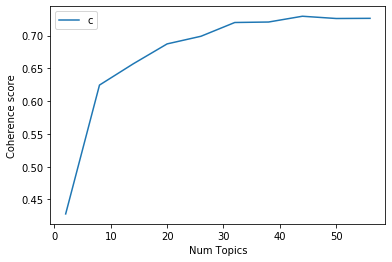

Num Topics = 2  has Coherence Value of 0.4279
Num Topics = 8  has Coherence Value of 0.6245
Num Topics = 14  has Coherence Value of 0.657
Num Topics = 20  has Coherence Value of 0.6874
Num Topics = 26  has Coherence Value of 0.699
Num Topics = 32  has Coherence Value of 0.72
Num Topics = 38  has Coherence Value of 0.7208
Num Topics = 44  has Coherence Value of 0.7296
Num Topics = 50  has Coherence Value of 0.7261
Num Topics = 56  has Coherence Value of 0.7264


In [14]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=60, step=6)

limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [15]:
# Select the best model and print
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.099*"safety" + 0.060*"downtown" + 0.060*"resident" + 0.055*"dog" + '
  '0.049*"work" + 0.044*"idea" + 0.044*"traffic" + 0.027*"friendly" + '
  '0.027*"development" + 0.022*"landscape"'),
 (1,
  '0.118*"create" + 0.083*"east_village" + 0.076*"neighborhood" + '
  '0.049*"bring" + 0.042*"barrio_logan" + 0.042*"require" + 0.035*"activate" + '
  '0.028*"effective" + 0.028*"free" + 0.021*"property"'),
 (2,
  '0.073*"live" + 0.073*"people" + 0.063*"park" + 0.058*"walk" + 0.047*"car" + '
  '0.037*"visit" + 0.026*"day" + 0.026*"vehicle" + 0.026*"time" + '
  '0.021*"high"'),
 (3,
  '0.235*"area" + 0.059*"feel" + 0.059*"small" + 0.035*"tourist" + '
  '0.035*"encourage" + 0.029*"local" + 0.024*"clean" + 0.018*"attraction" + '
  '0.018*"offer" + 0.018*"neighbor"'),
 (4,
  '0.095*"place" + 0.077*"art" + 0.047*"provide" + 0.041*"quality" + '
  '0.036*"concept" + 0.030*"access" + 0.030*"artist" + 0.024*"entire" + '
  '0.024*"major" + 0.018*"restaurant"'),
 (5,
  '0.108*"people" + 0.045*"gree

In [17]:
### find dominant topic in each sentence

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
    
#     print(corpus)
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,13.0,0.0993,"street, activity, building, find, event, imple...",A structure or monument at the Nudillo could i...
1,1,10.0,0.0949,"area, impact, feasible, market, build, city, l...",The built form should be lit at night.
2,2,0.0,0.0929,"safety, downtown, resident, dog, work, idea, t...","More than a plaza, the space can be activated ..."
3,3,5.0,0.0975,"people, green, love, bike, element, store, rea...",The structure could incorporate an observation...
4,4,11.0,0.0896,"public, great, project, restrict, problem, giv...",I think its a great idea
5,5,3.0,0.0847,"area, feel, small, tourist, encourage, local, ...",I want the color of the tower at El Nudillo to...
6,6,5.0,0.1433,"people, green, love, bike, element, store, rea...",Any type of color realms of blue green and san...
7,7,0.0,0.0879,"safety, downtown, resident, dog, work, idea, t...",I am not sure how it will impact safety
8,8,10.0,0.0879,"area, impact, feasible, market, build, city, l...",how do you think......(building a tower) might...
9,9,0.0,0.0714,"safety, downtown, resident, dog, work, idea, t...",Not at all.


### most representative document for each topic

In [18]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1808,"safety, downtown, resident, dog, work, idea, t...",I have come up with these idea to maximize saf...
1,1.0,0.1711,"create, east_village, neighborhood, bring, bar...",Creating a link between Barrio Logan and East ...
2,2.0,0.2148,"live, people, park, walk, car, visit, day, veh...",Would have to respect age/ability/and why the ...
3,3.0,0.1383,"area, feel, small, tourist, encourage, local, ...","Now, the area is void of positive activity. Th..."
4,4.0,0.1811,"place, art, provide, quality, concept, access,...",Why not have a three or four story observatory...


### topic distribution across documents

In [19]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,13.0,"street, activity, building, find, event, imple...",45.0,0.1308
1.0,10.0,"area, impact, feasible, market, build, city, l...",19.0,0.0552
2.0,0.0,"safety, downtown, resident, dog, work, idea, t...",26.0,0.0756
3.0,5.0,"people, green, love, bike, element, store, rea...",22.0,0.0640
4.0,11.0,"public, great, project, restrict, problem, giv...",27.0,0.0785
...,...,...,...,...
339.0,13.0,"street, activity, building, find, event, imple...",NaN,NaN
340.0,0.0,"safety, downtown, resident, dog, work, idea, t...",NaN,NaN
341.0,10.0,"area, impact, feasible, market, build, city, l...",NaN,NaN
342.0,11.0,"public, great, project, restrict, problem, giv...",NaN,NaN
